In [1]:
from PIL import Image, ImageChops
import math
import numpy as np
import imageio as io
from skimage import img_as_float
from skimage.measure import compare_mse as mse
from skimage.util import crop

#function that calculates the root mean square error between im1 and im2
def rmsdiff(im1, im2):
    """Calculates the root mean square error (RSME) between two images"""
    return math.sqrt(mse(img_as_float(im1), img_as_float(im2)))

#Loads and crops im1 and im2 for rmsdiff function
#loops im2 loader through t dimension in data series
for x in range(0, 18):
    im1 = io.volread('E:/paper_2/vol0_binary.tif')
    im2 = io.volread("E:/paper_2/Registration_Volumes/cropped_TiffSaver-tomo_C%d.tif"%(x))
    print(f"RMS of tomo %d = {rmsdiff(im1[102:498, 102:198, 102:498], im2[102:498, 102:198, 102:498])}"%(x))

#load into excel to plot similarity to im0 overtime
#would expect to see the graddient slope slowly up due to deposit at a constant rate
#step increases in gradient may be due to misalignment
#misalignment should be corrected by a registration method
#because the images are already quite closely aligned an exhuastive method may be appropriate using a 3D euler tranform

RMS of tomo 0 = 0.43236121729750515
RMS of tomo 1 = 0.4370755026579466
RMS of tomo 2 = 0.4372008661607103
RMS of tomo 3 = 0.4379802394844278
RMS of tomo 4 = 0.42763123929861296
RMS of tomo 5 = 0.43225582170523635
RMS of tomo 6 = 0.4347535545037007
RMS of tomo 7 = 0.43533490582297324
RMS of tomo 8 = 0.4358897288358018
RMS of tomo 9 = 0.43750907741134615
RMS of tomo 10 = 0.4369540096234049
RMS of tomo 11 = 0.4383242168688672
RMS of tomo 12 = 0.44976141177254775
RMS of tomo 13 = 0.42956416729976993
RMS of tomo 14 = 0.42956416729976993
RMS of tomo 15 = 0.4291676848170026
RMS of tomo 16 = 0.4297422825959473
RMS of tomo 17 = 0.4293957074969428


(396, 96, 396)


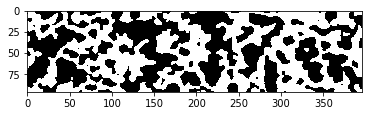

In [5]:
#to check we have analysed correct shape/image region
import matplotlib.pyplot as plt
print(im1[102:498, 102:198, 102:498].shape)
plt.imshow(im1[0, 102:198, 102:498], cmap = 'gray')


Point (1.0, 1.0, 1.0) transformed is (1.0, 1.0, 1.0)


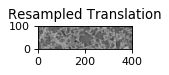

In [18]:
from __future__ import print_function
import SimpleITK as sitk
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from ipywidgets import interact, fixed

#the dimension of the image and the origin
dimension = 3
point = (1.0, 1.0, 1.0)
#this function will print where the origin will be translated to 
def transform_point(transform, point):
    transformed_point = transform.TransformPoint(point)
    print('Point ' + str(point) + ' transformed is ' + str(transformed_point))
#this function will visualises
def myshow(img, title=None, margin=0.05, dpi=80):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()    
    ysize = nda.shape[0]
    xsize = nda.shape[1]  
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    if(title):
        plt.title(title)
#this function executes the resampling
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)

moving_image = sitk.ReadImage("E:/paper_2/Registration_Volumes/cropped_TiffSaver-tomo_C1.tif", sitk.sitkFloat32)
moving_image_cropped = moving_image[100:500, 100:200, 100:500]
translation = sitk.TranslationTransform(dimension)
translation.SetParameters((0.0, 0.0, 0.0))
translation.SetOffset((0.0, 0.0, 0.0))
transform_point(translation, point)
resampled = resample(moving_image_cropped, translation)
myshow(resampled[:, :, 50], 'Resampled Translation')

Point (1.0, 1.0, 1.0) transformed is (1.0, 1.0, 1.0)


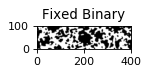

In [19]:
fixed_image = sitk.ReadImage("E:/paper_2/vol0_binary.tif", sitk.sitkFloat32)
fixed_image_cropped = fixed_image[100:500, 100:200, 100:500]
translation_0 = sitk.TranslationTransform(dimension)
translation_0.SetParameters((0.0, 0.0, 0.0))
translation_0.SetOffset((0.0, 0.0, 0.0))
transform_point(translation_0, point)
resampled_0 = resample(fixed_image_cropped, translation_0)
myshow(resampled_0[:, :, 50], 'Fixed Binary')

In [20]:
RMS0 = (sitk.GetArrayFromImage(resampled_0[2:398, 2:98, 2:398])).astype('uint8')
RMS1 = (sitk.GetArrayFromImage(resampled[2:398, 2:98, 2:398])).astype('uint8')
print(rmsdiff(RMS0, RMS1))


0.4370755026579466


In [14]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkNearestNeighbor)  #This is the least computationally demanding interpolator 
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[0,0,0,25,25,25], stepLength = 0.06667) 
registration_method.SetOptimizerScales([1,1,1,1,1,1])

#Perform the registration in-place so that the initial_transform is modified.
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.Execute(fixed_image_cropped, moving_image_cropped)

print('best transformation is: ' + str(initial_transform.GetParameters()))



best transformation is: (0.0, 0.0, 0.0, 0.0, -1.0000499999999999, 0.0)


Point (1.0, 1.0, 1.0) transformed is (1.0, -4.999999999988347e-05, 1.0)


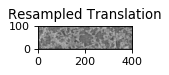

In [21]:
translation_test = sitk.TranslationTransform(dimension)
translation_test.SetParameters((0.0, -1.0000499999999999, 0.0))
translation.SetOffset((0.0, -1.0000499999999999, 0.0))
transform_point(translation_test, point)
resampled_test = resample(moving_image_cropped, translation_test)
myshow(resampled_test[:, :, 50], 'Resampled Translation')

In [22]:
RMS0_test = (sitk.GetArrayFromImage(resampled_0[2:398, 2:98, 2:398])).astype('uint8')
RMS1_test = (sitk.GetArrayFromImage(resampled_test[2:398, 2:98, 2:398])).astype('uint8')
print(rmsdiff(RMS0_test, RMS1_test))

0.4280172906639559


In [24]:
# we have shown that this method improves the registration of the subsequent grayscale images onto the binary
# i.e because the RMSE is less after the translation
# now we loop the volumes through the above code in order to apply to the whole set
for x in range(1, 18):
    moving_image = sitk.ReadImage("E:/paper_2/Registration_Volumes/cropped_TiffSaver-tomo_C%d.tif"%(x), sitk.sitkFloat32)
    moving_image_cropped = moving_image[100:500, 100:200, 100:500]
    registration_method.SetInitialTransform(initial_transform, inPlace=True)
    registration_method.Execute(fixed_image_cropped, moving_image_cropped)
    print('best transformation %d: '%(x) + str(initial_transform.GetParameters()))

best transformation 1: (0.0, 0.0, 0.0, 0.0, -1.0000499999999999, 0.0)
best transformation 2: (0.0, 0.0, 0.0, 0.0, -1.13339, 0.0)
best transformation 3: (0.0, 0.0, 0.0, 0.0, -1.0000499999999999, 0.0)
best transformation 4: (0.0, 0.0, 0.0, 0.0, -1.0000499999999999, 0.0)
best transformation 5: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, 0.0)
best transformation 6: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, 0.0)
best transformation 7: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, 0.0)
best transformation 8: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, -0.8000399999999999)
best transformation 9: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, -1.0000499999999999)
best transformation 10: (0.0, 0.0, 0.0, -1.0000499999999999, -1.0000499999999999, -1.0000499999999999)
best transformation 11: (0.0, 0.0, 0.0, 0.0, 0.6666999999999998, -1.0000499999999999)
best transformation 12: (0.0, 0.0, 0.0, 0.0, 2.0000999999999998, -1.000049999999

In [41]:
#now we will manually input the translations above to calculate the RMSE at each tomogram and plot this in excel
moving_image = sitk.ReadImage("E:/paper_2/Registration_Volumes/cropped_TiffSaver-tomo_C17.tif", sitk.sitkFloat32)
moving_image_cropped = moving_image[100:500, 100:200, 100:500]
translation_test = sitk.TranslationTransform(dimension)
translation_test.SetParameters((0.0, 1.0000499999999999, -1.0000499999999999))
translation.SetOffset((0.0, 1.0000499999999999, -1.0000499999999999))
transform_point(translation_test, point)
resampled_test = resample(moving_image_cropped, translation_test)
RMS0_test = (sitk.GetArrayFromImage(resampled_0[2:398, 2:98, 2:398])).astype('uint8')
RMS1_test = (sitk.GetArrayFromImage(resampled_test[2:398, 2:98, 2:398])).astype('uint8')
print(rmsdiff(RMS0_test, RMS1_test))

Point (1.0, 1.0, 1.0) transformed is (1.0, 2.00005, -4.999999999988347e-05)
0.4283323542021218


In [42]:
#Registration Acheived!